In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from nbvis import plotNb
from matplotlib import pyplot as plt
import scipy
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("NotebookCategoryInfo.csv",index_col=0)

## Extracting Features by Estimating Transition Probabilities

In [3]:
macro_dict = {'join':'ingestion', 'create':'ingestion', 'print':'inspect', 'plot':'inspect',
                'preprocessing':'wrangling', 'group':'wrangling', 'cleaning':'wrangling', 
                'model':'model', 'postprocessing':'compute', 'stats':'compute', 'other':'other'} 
df['macrocategory']= df['category'].map(macro_dict)

In [4]:
mat = []
mat2 = []
for nbName in df.name.unique():
    categoryList = list(df[df['name']==nbName]['category'])
    macroCatLst = list(df[df['name']==nbName]['macrocategory'])
    mat += [categoryList]
    mat2 += [macroCatLst]


In [5]:
indexMap = {'join':3, 'create':0, 'print':4, 'plot':6,
                'preprocessing':8, 'group':2, 'cleaning':1, 
                'model':5, 'postprocessing':9, 'stats':7, 'other':10}

macroIndexMap = {'ingestion':0, 'inspect':1, 'wrangling':2, 'model':3,
                'compute':4, 'other':5}

In [6]:
# taken from https://stackoverflow.com/questions/46657221/generating-markov-transition-matrix-in-python
def transitionMatrix(transitions, isMacro):
    if isMacro:
        iMap = macroIndexMap
    else:
        iMap = indexMap
    n = len(iMap.keys()) #number of states
    M = [[0]*n for _ in range(n)]
    for (i,j) in zip(transitions,transitions[1:]):
        M[iMap[i]][iMap[j]] += 1        

    #now convert to probabilities
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return np.array(M)  

In [7]:
def proportions(lines, isMacro):
    if isMacro:
        iMap = macroIndexMap
    else:
        iMap = indexMap
    labels = list(iMap.keys())
    labels.remove('other')
    proportions = {}
    for label in labels:
        count = 0
        for val in lines:
            if val == label:
                count += 1
        proportions[label] = count

    totalProp = sum(proportions.values())
    if totalProp == 0:
        totalProp = 1
    for k in proportions.keys():
        proportions[k] = proportions[k]/totalProp
    return proportions

In [8]:
def quartile_analysis(mat, isMacro=False):
    proportions = {}
    if isMacro:
            iMap = macroIndexMap
    else:
        iMap = indexMap
    labels = list(iMap.keys())
    labels.remove('other')
    for label in labels:
        labelDict = {}
        for lines in mat:
            for q in range(4):
                count = 0
                for val in lines[q*len(lines)//4:(q+1)*len(lines)//4]:
                    if val == label:
                        count += 1
                if q in labelDict.keys():
                    labelDict[q] += count
                else:
                    labelDict[q] = count
        proportions[label] = labelDict

    cat_quart = proportions
    barWidth = 0.2

    # set height of bar
    bars1 = []
    bars2 = []
    bars3 = []
    bars4 = []

    for k, v in cat_quart.items():
        bars1 += [cat_quart[k][0]]
        bars2 += [cat_quart[k][1]]
        bars3 += [cat_quart[k][2]]
        bars4 += [cat_quart[k][3]]

    # Set position of bar on X axis
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]

    # Make the plot
    plt.bar(r1, bars1, width=barWidth, edgecolor='white', label='quartile0')
    plt.bar(r2, bars2, width=barWidth, edgecolor='white', label='quartile1')
    plt.bar(r3, bars3, width=barWidth, edgecolor='white', label='quartile2')
    plt.bar(r4, bars4, width=barWidth, edgecolor='white', label='quartile3')

    # Add xticks on the middle of the group bars
    plt.xlabel('Categories')
    plt.xticks([r + barWidth for r in range(len(bars1))], cat_quart.keys())
    plt.xticks(rotation=90)
    plt.ylabel("Number of Lines")
    plt.title("Category Quartile Distribution")
#     plt.rcParams["figure.figsize"] = (15,8)

    # Create legend & Show graphic
    plt.legend()
    plt.show()

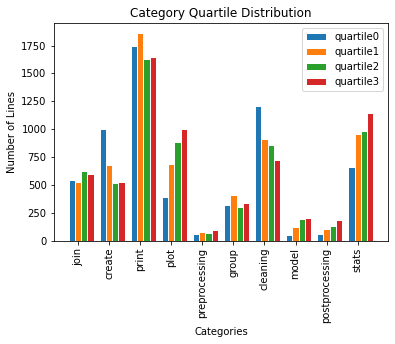

In [9]:
quartile_analysis(mat)

In [10]:
featureMatrix = []
catMat = []
macroCatMat = []
for i in range(len(mat)):
    features = []
    lst = mat[i]
    tMat = transitionMatrix(lst, False)
    features.extend(tMat.flatten())
    catMat.append(tMat)
    props = proportions(lst, False)
    features.extend(props.values())
    lst2=mat2[i]
    props = proportions(lst2, True)
    tMat = transitionMatrix(lst2, True)
    features.extend(tMat.flatten())
    macroCatMat.append(tMat) 
    features.extend(props.values())
    featureMatrix.append(features)
    # Add Features here (eg length, flattened transition matrix between macro categories, etc.)

## Adding Package Tracking

In [11]:
packages = ['numpy', 'matplotlib', 'pandas', 'sklearn', 'os', 'scipy', 'seaborn']
for package in packages:
    df[package] = df['text'].str.contains(package)
package_features = df.groupby('name').any().loc[:,'numpy':'seaborn'].values


In [12]:
featureMatrix = np.array(featureMatrix)
# featureMatrix = np.concatenate((featureMatrix, package_features), axis=1)
featureMatrix.shape

(584, 172)

##  Heatmap for Transition Matrices

In [13]:
def visualize_transition_matrix(avg_transition_matrix, isMacro=False, withOther=False):
    if isMacro:
        iMap = macroIndexMap
    else:
        iMap = indexMap
    labels = list(indexMap.keys())
    if not withOther:
        otherIndex = iMap['other']
        avg_transition_matrix = np.delete(avg_transition_matrix, otherIndex, 0)
        avg_transition_matrix = np.delete(avg_transition_matrix, otherIndex, 1)
        labels.remove('other')
    ax = sns.heatmap(avg_transition_matrix, cmap="Blues")
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.title("Heatmap of Category Transition Matrix")
    plt.show()

In [14]:
avg_macro_transition_matrix = np.mean(np.array(macroCatMat), axis = 0)
avg_transition_matrix = np.mean(np.array(catMat), axis = 0)

In [15]:
# visualize_transition_matrix(avg_transition_matrix, isMacro=False, withOther=True)

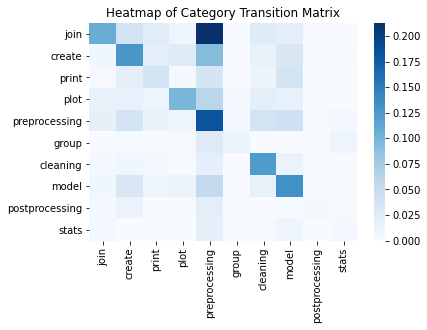

In [16]:
visualize_transition_matrix(avg_transition_matrix, isMacro=False, withOther=False)

In [17]:
# visualize_transition_matrix(avg_macro_transition_matrix, isMacro=True, withOther=True)

In [18]:
# visualize_transition_matrix(avg_macro_transition_matrix, isMacro=True, withOther=False)

## Dendrogram Code

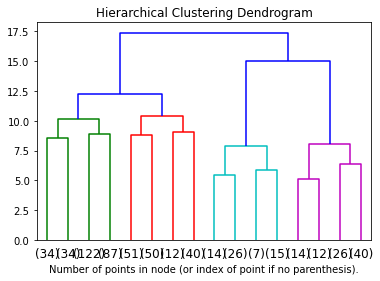

In [19]:
# Code based on : https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(featureMatrix)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [20]:
scaler = StandardScaler()
X_std = scaler.fit_transform(featureMatrix)

## Performing Clustering

In [21]:
num_clusters = 4
clustering = AgglomerativeClustering(n_clusters=num_clusters).fit(featureMatrix)
labels = pd.Series(clustering.labels_,name="Cluster")
labels.value_counts()

1    277
0    153
3     92
2     62
Name: Cluster, dtype: int64

In [22]:
df2 = pd.DataFrame(featureMatrix)
df2['label'] = clustering.labels_
df2 = df2.set_index(df.name.unique())
df2.to_csv('FeaturesAndLabels.csv')


In [23]:
def visualize_clusters(df, labels, clusterID, Nsample=5):
    all_nbs=df.name.unique()
    nbIdx = np.where(labels==clusterID)[0]
    clustNb = list(all_nbs[nbIdx])
    clustDf = df[df["name"].isin(clustNb)]
    indices = list(clustDf.groupby("name").count().iloc[:Nsample,:].sort_values("line").index)
    plotNb(df,indices)
    
    # print ("Top 5 most common categories based on average occurence of categories in cluster", clustDf.groupby("category")["line"].mean().sort_values(ascending=False)[:5])
    # print ("Average number of lines of each series in cluster",clustDf.groupby("name").count()["line"].mean())
    # print ("Average number of cells of each series in cluster",clustDf[["name","cell"]].drop_duplicates().groupby("name").count().mean()["cell"])

In [24]:
def visualize_cluster_transition_matrices(df, labels, clusterID, isMacro=False):
    all_nbs=df.name.unique()
    nbIdx = np.where(labels==clusterID)[0]
    clustNb = list(all_nbs[nbIdx])
    clustDf = df[df["name"].isin(clustNb)]
    mat = []
    mat2 = []
    for nbName in clustDf.name.unique():
        categoryList = list(df[df['name']==nbName]['category'])
        macroCatLst = list(df[df['name']==nbName]['macrocategory'])
        mat += [categoryList]
        mat2 += [macroCatLst]
    quartile_analysis(mat)
    catMats = []
    macroCatMats = []
    for i in range(len(mat)):
        lst = mat[i]
        tMat = transitionMatrix(lst, False)
        catMats.append(tMat)
        lst=mat2[i]
        tMat = transitionMatrix(lst, True)
        macroCatMats.append(tMat) 
    avg = np.mean(np.array(catMats), axis=0)
    otherIndex = indexMap['other']
    visualize_transition_matrix(avg, isMacro=False, withOther=False)
    
    avg = np.mean(np.array(macroCatMats), axis=0)
    visualize_transition_matrix(avg, isMacro=True, withOther=False)


In [25]:
# visualize_clusters(df,clustering.labels_, 0, Nsample=10)

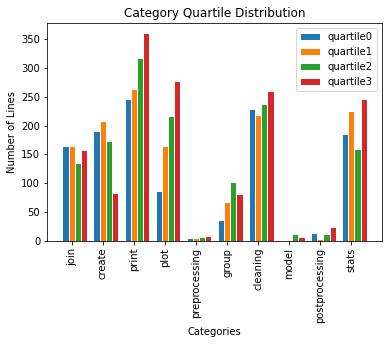

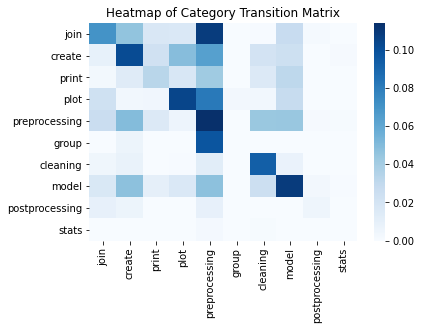

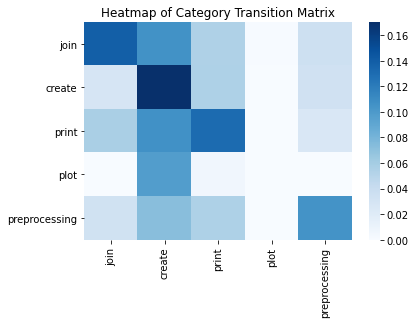

In [26]:
visualize_cluster_transition_matrices(df, clustering.labels_, 0)

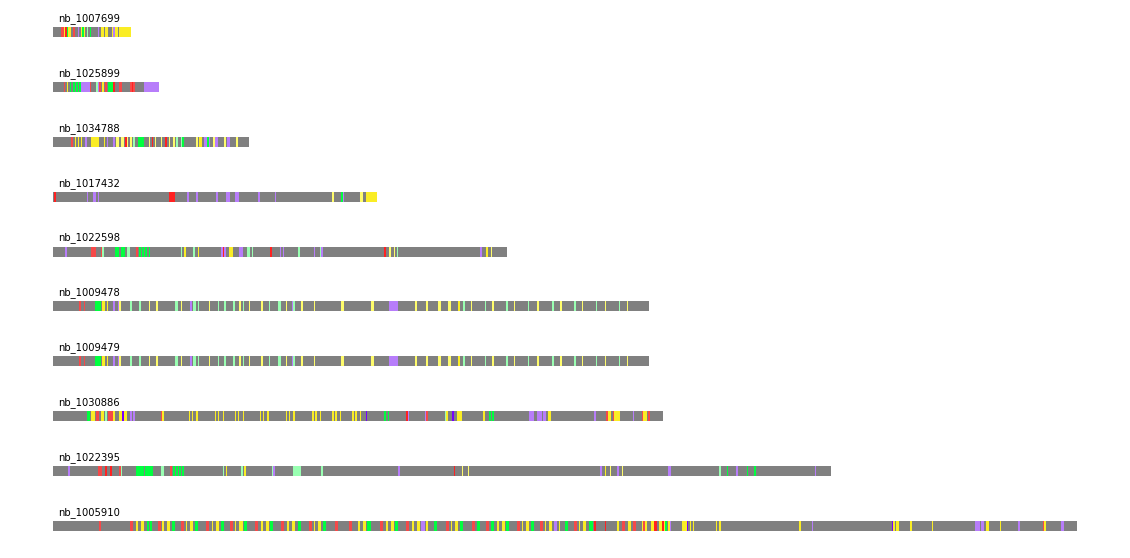

In [27]:
visualize_clusters(df,clustering.labels_, 1, Nsample=10)

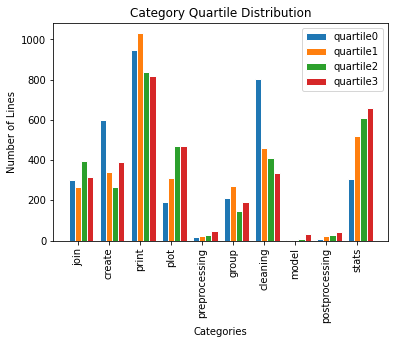

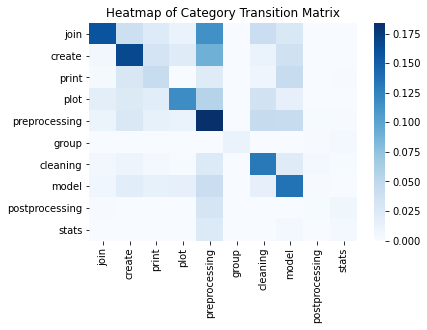

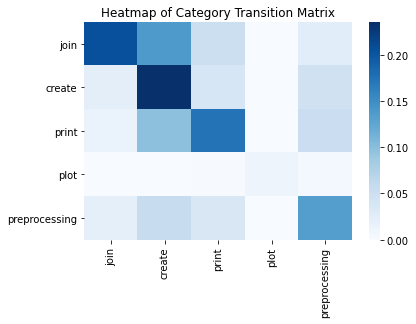

In [28]:
visualize_cluster_transition_matrices(df, clustering.labels_, 1)

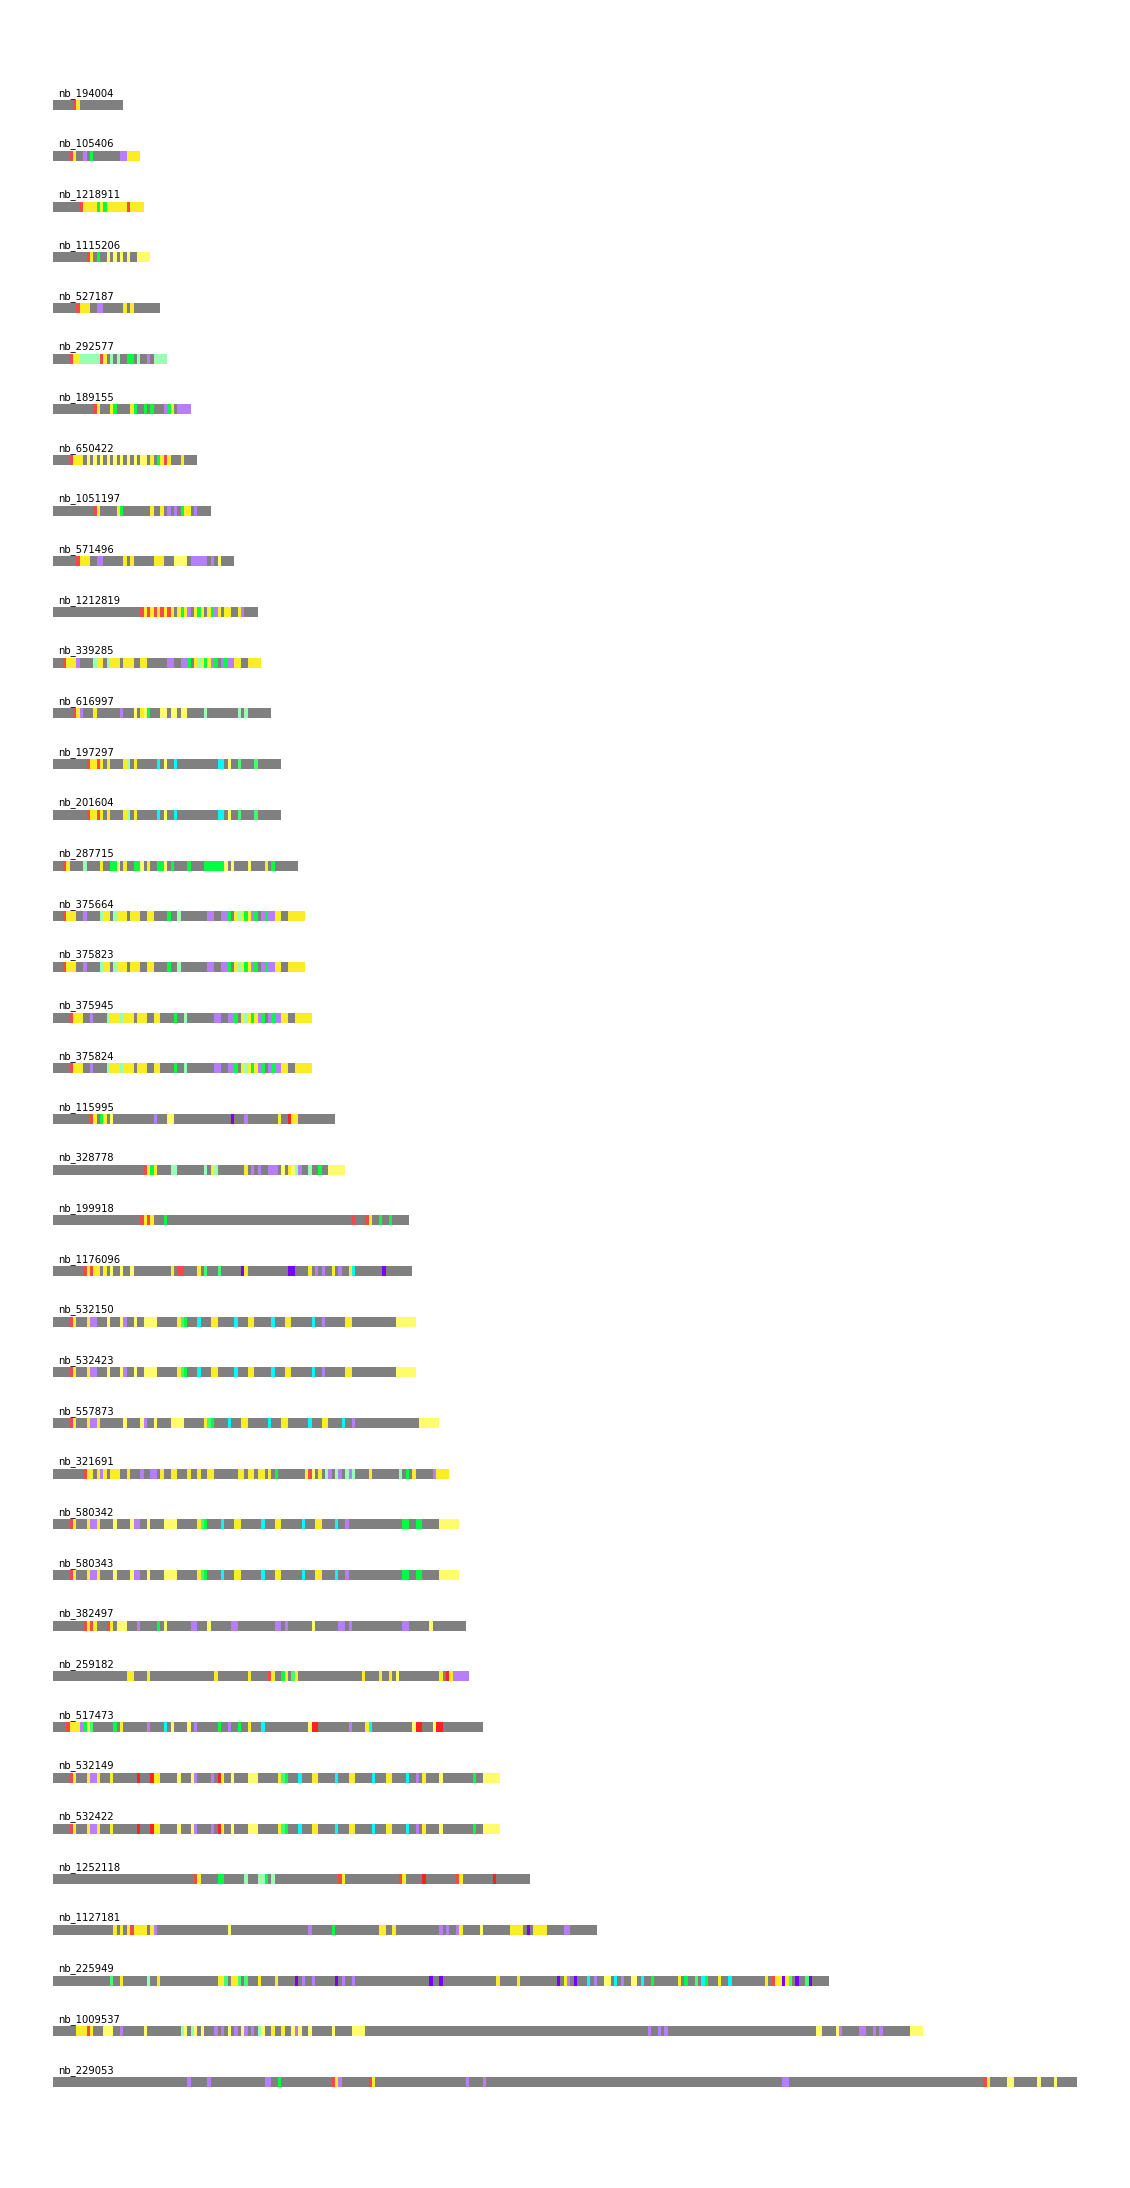

In [29]:
visualize_clusters(df,clustering.labels_, 2, Nsample=40)

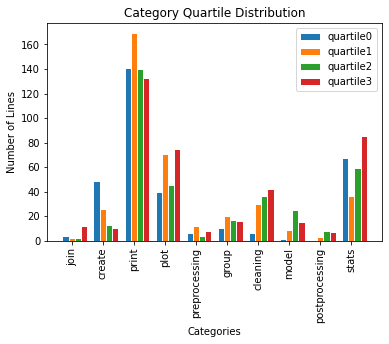

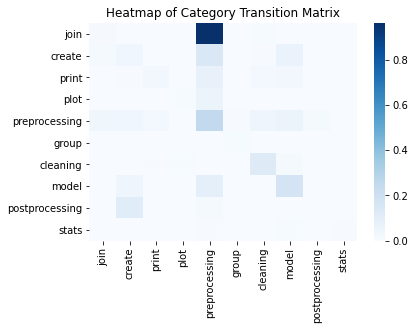

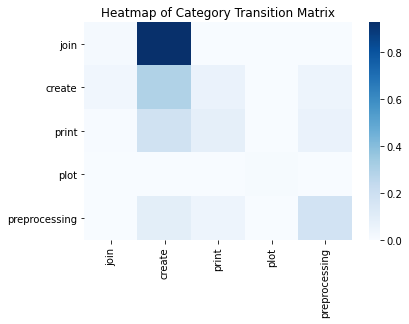

In [30]:
visualize_cluster_transition_matrices(df, clustering.labels_, 2)

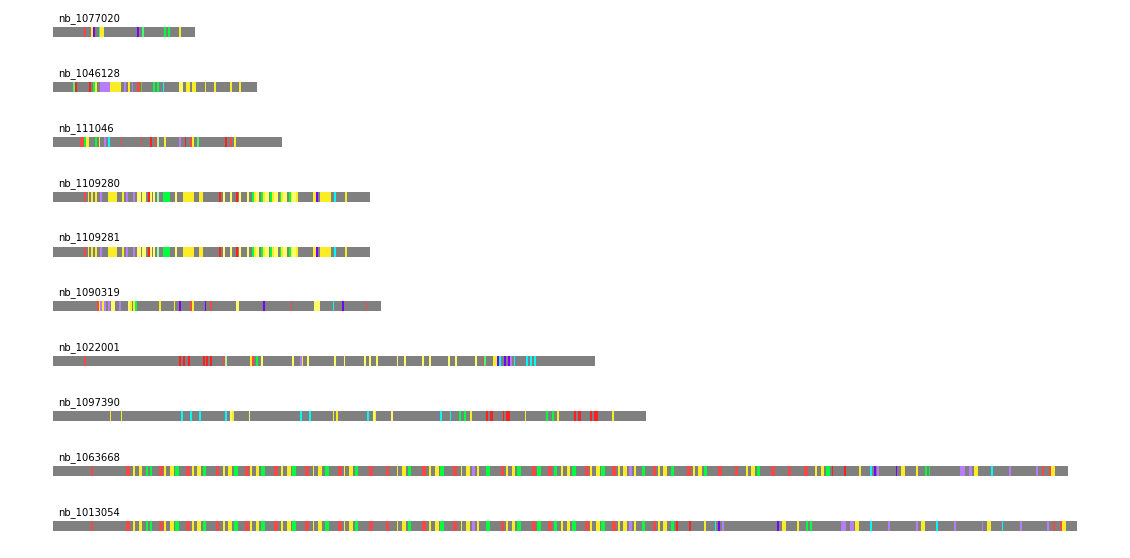

In [31]:
visualize_clusters(df,clustering.labels_, 3, Nsample=10)

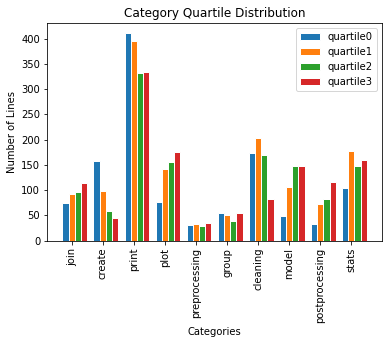

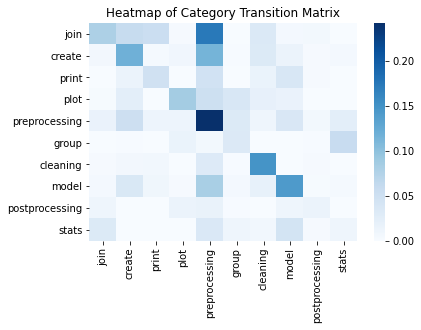

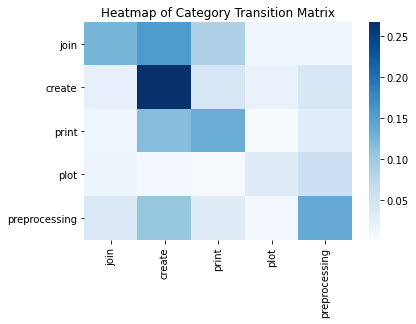

In [32]:
visualize_cluster_transition_matrices(df, clustering.labels_, 3)

In [33]:
def visualize_package_freq(df, labels):
    all_nbs=df.name.unique()
    values = []
    for clusterID in range(4):
        nbIdx = np.where(labels==clusterID)[0]
        clustNb = list(all_nbs[nbIdx])
        clustDf = df[df["name"].isin(clustNb)]
        packages = ['numpy', 'matplotlib', 'pandas', 'sklearn', 'os', 'scipy', 'seaborn']
        packageDf = clustDf.groupby('name').any().loc[:,'numpy':'seaborn']
        arr = []
        for package in packages:
            percentTrue = round(packageDf[package].value_counts(normalize=True)[1], 3)
    #         print(str(percentTrue) + " of notebooks have package: " + package)
            arr += [percentTrue]
        values += [arr]
    # set width of bar
    barWidth = 0.2

    # set height of bar
    bars1 = values[0]
    bars2 = values[1]
    bars3 = values[2]
    bars4 = values[3]

    # Set position of bar on X axis
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]

    # Make the plot
    plt.bar(r1, bars1, width=barWidth, edgecolor='white', label='cluster0')
    plt.bar(r2, bars2, width=barWidth, edgecolor='white', label='cluster1')
    plt.bar(r3, bars3, width=barWidth, edgecolor='white', label='cluster2')
    plt.bar(r4, bars4, width=barWidth, edgecolor='white', label='cluster3')

    # Add xticks on the middle of the group bars
    plt.xlabel('packages')
    plt.xticks([r + barWidth for r in range(len(bars1))], packages)
    plt.xticks(rotation=90)
    plt.ylabel("Percent of Notebooks")
    plt.title("Cluster Package Import Frequency")
#     plt.rcParams["figure.figsize"] = (15,8)

    # Create legend & Show graphic
    plt.legend()
    plt.show()


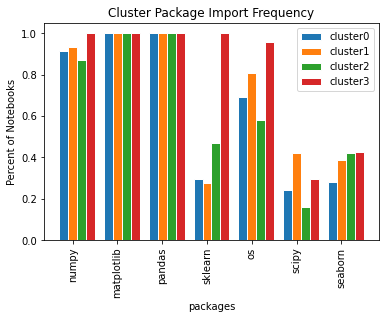

In [34]:
visualize_package_freq(df, clustering.labels_)

In [35]:
def visualize_cluster_quartile(df, cluster_labels, isMacro = False):
    all_nbs=df.name.unique()
    
    if isMacro:
        iMap = macroIndexMap
    else:
        iMap = indexMap
    labels = list(iMap.keys())
    labels.remove('other')
    
    values = {}
    
    for clusterID in range(4):
        nbIdx = np.where(cluster_labels==clusterID)[0]
        clustNb = list(all_nbs[nbIdx])
        clustDf = df[df["name"].isin(clustNb)]
        mat = []
        mat2 = []
        for nbName in clustDf.name.unique():
            categoryList = list(df[df['name']==nbName]['category'])
            macroCatLst = list(df[df['name']==nbName]['macrocategory'])
            mat += [categoryList]
            mat2 += [macroCatLst]
        for q in range(4):
            count = 0
            for lines in mat:
                for val in lines[q*len(lines)//4:(q+1)*len(lines)//4]:
                    if val == 'cleaning':
                        count += 1
            if q in values.keys():
                values[q].append(count)
            else:
                values[q] = [count]
        
    # set width of bar
    barWidth = 0.2

    # set height of bar
    bars1 = values[0]
    bars2 = values[1]
    bars3 = values[2]
    bars4 = values[3]

    # Set position of bar on X axis
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]

    # Make the plot
    plt.bar(r1, bars1, width=barWidth, edgecolor='white', label='cluster0')
    plt.bar(r2, bars2, width=barWidth, edgecolor='white', label='cluster1')
    plt.bar(r3, bars3, width=barWidth, edgecolor='white', label='cluster2')
    plt.bar(r4, bars4, width=barWidth, edgecolor='white', label='cluster3')

    # Add xticks on the middle of the group bars
    plt.xlabel('Quartiles')
    plt.xticks([r + barWidth for r in range(len(bars1))], ['quartile0', 'quartile1', 'quartile2', 'quartile3'])
    plt.xticks(rotation=90)
    plt.ylabel("Number of Lines")
    plt.title("Cluster Quartile Analysis for Cleaning")
#     plt.rcParams["figure.figsize"] = (15,8)

    # Create legend & Show graphic
    plt.legend()
    plt.show()


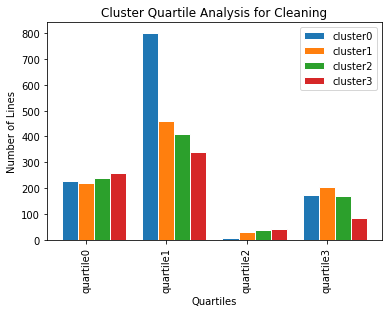

In [36]:
visualize_cluster_quartile(df, clustering.labels_)

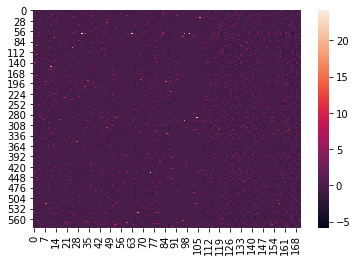

In [37]:
sns.heatmap(X_std)

In [38]:
def graphFnCountDist(d, title):
    # Plot bar chart of fn raw counts
    plt.bar(range(len(d)), list(d.values()), align='center')
    plt.xticks(range(len(d)), list(d.keys()))
    plt.xticks(rotation=90)
    plt.title(str(title) + " Function Distribution (Counts)")
    plt.xlabel("Function Names")
    plt.ylabel("Number of Lines (Total n=" + str(sum(linesPerCell.values())) + ")")
    plt.show()
    # Plot bar chart of fn proportion within category
    plt.bar(range(len(d)), np.array(list(d.values()))/sum(d.values()), align='center')
    plt.xticks(range(len(d)), list(d.keys()))
    plt.xticks(rotation=90)
    plt.title(str(title) + " Function Distribution (Proportion)")
    plt.xlabel("Function Names")
    plt.ylabel("Proportion of " + str(title) + " Lines (Total n=" + str(sum(linesPerCell.values())) + ")")
    plt.show()

## Copying Clustered NBs into separate folders

In [39]:
import os

cwd = os.getcwd()
dir = os.path.join(cwd, "..", "clusters")
if not os.path.exists(dir):
    os.mkdir(dir)
    for i in range(num_clusters):
        dir = os.path.join(cwd, "..", "clusters",str(i))
        os.mkdir(dir)
else:
    print("Error: clusters folder already exists. Please remove and try again.")


In [41]:
import shutil
for index, row in df2.iterrows():
    shutil.copy("../../filteredSample/"+index+'.ipynb',"../clusters/"+str(int(row['label'])))
